# Music Genre and Composer Classification Using Deep Learning 

` Authors: Zain Ali, Angel Benitez, and Outhai Xayavongsa`



## Introduction

In this project, we employ deep learning to classify classical music compositions by their composers. Leveraging a dataset of 3,929 MIDI files from 175 composers—including Bach, Beethoven, Chopin, and Mozart—we develop Long Short-Term Memory (LSTM)  and Convolutional Neural Network (CNN) models to identify the Composer of a given piece. Initially, we concentrate on the four mentioned composers to fine-tune our approach. In the end, we created a model encompassing all 145 composers in the dataset, assessing its generalization capabilities across diverse musical styles. We also performed optimizations and many other techniques to get the best models within the last few weeks. 


If you would like more information about the files or need access to the full project, please go to our GitHub repository: https://github.com/zainnobody/AAI-511-Final-Project. Feel free to fork or clone it. The README file also contains more information. 

Note: Artist and Composer are two words used to describe the creators of classical music, which is now in MIDI format. In this notebook, we use Artist, and the paper and other content use Composer.  

### Libraries Import

Following are all the libraries and packages used within our project.

In [4]:
import os
import shutil
import zipfile
import random
import time
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mido
from mido import MidiFile, bpm2tempo, tick2second
import pretty_midi
import pygame

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

from keras import backend


### Global Variables

The following variables were used throughout the project. Although the variables are used globally, they were not used as constants, so they are not all capitalized. If you are cloning the GitHub, feel free to change the values. 

In [18]:
# Directory where the raw data will be extracted
raw_data_zip = "raw_data/midi_classic_music_data.zip"  # Location of the zip file
raw_data_extracted = "raw_data_unzipped"  # Location where you would like the zip file to extract everything
specific_artists = [
    "Bach",
    "Beethoven",
    "Chopin",
    "Mozart",
]  # These are used for the initial LSTM and CNN analysis


## Data Collection

The data was quite unorganized and downloaded in a zip format. Several steps were taken to make the data useful and well organized. Get more information about the data within Kaggle at: https://www.kaggle.com/datasets/blanderbuss/midi-classic-music. 

In [ ]:
# Function to delete a directory and its contents
def delete_dir(dir_to_delete):
    try:
        file_count = sum([len(files) for r, d, files in os.walk(dir_to_delete)])
        shutil.rmtree(dir_to_delete)
        print(f"Directory {dir_to_delete} and all its contents ({file_count} files) have been successfully deleted.")
    except Exception as e:
        print(f"An error occurred while trying to delete the directory: {e}")

In [34]:
# Function to unzip
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

In [35]:
# Function to move contents of a directory up one level
def move_contents_up_one_dir(path):
    path = os.path.abspath(path)
    parent_dir = os.path.dirname(path)
    if path == parent_dir or not os.path.exists(path):
        print("Operation not allowed or path does not exist.")
        return
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), os.path.join(parent_dir, item))
    os.rmdir(path)
    print(f"All contents moved from {path} to {parent_dir} and directory removed.")

In [36]:
# Function to rename .MID files to .mid for consistency 
def rename_mid_files(directory):
    rename_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.MID'):
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, file[:-4] + '.mid')
                os.rename(old_file_path, new_file_path)
                rename_count += 1
    return rename_count

In [ ]:
# Function to delete .zip files
def delete_zip_files(directory):
    delete_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                delete_count += 1
    return delete_count

In [37]:
# Function to Move Folder Contents
def move_folder_contents(src_folder, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    for item in os.listdir(src_folder):
        src_item = os.path.join(src_folder, item)
        dest_item = os.path.join(dest_folder, item)
        
        if os.path.isdir(src_item):
            shutil.move(src_item, dest_folder)
        else:
            shutil.move(src_item, dest_item)
    
    delete_dir(src_folder)

In [10]:
# Funtion to move the content of the corrected directory
def directory_name_corrections(name_corrections_dirs):
    for src_folder, dest_folder in name_corrections_dirs.items():
        src_path = os.path.join(raw_data_extracted, src_folder)
        dest_path = os.path.join(raw_data_extracted, dest_folder)
        print(f"Moving contents from {src_path} to {dest_path}...")
        move_folder_contents(src_path, dest_path)

    print("Folder contents moved and directories deleted successfully.")

In [38]:
# Function to Categorize Files by Directory
def categorize_files_by_dir(path):
    files_and_dirs = os.listdir(path)
    directories = {name for name in files_and_dirs if os.path.isdir(os.path.join(path, name))}
    categorized_files = {}
    unassigned_files = {}

    for file_name in files_and_dirs:
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.mid'):
            first_word = file_name.split()[0]
            if first_word in directories:
                if first_word not in categorized_files:
                    categorized_files[first_word] = []
                categorized_files[first_word].append(file_name)
            else:
                if first_word not in unassigned_files:
                    unassigned_files[first_word] = []
                unassigned_files[first_word].append(file_name)

    print("Categorized Files Summary:")
    for key, files in categorized_files.items():
        print(f"Artist {key}: {len(files)} files")

    print("\nUnassigned Files Summary:")
    for key, files in unassigned_files.items():
        print(f"Artist {key}: {len(files)} files")
    
    return categorized_files, unassigned_files, sorted(directories)

In [11]:
# Function to Display Information about Categorized and Unassigned Files
def display_info(categorized_files, unassigned_files):
    print("Categorized Files Summary:")
    for key, files in categorized_files.items():
        print(f"Artist '{key}': {len(files)} files")
    
    print("\nUnassigned Files Summary:")
    if unassigned_files:
        for key, files in unassigned_files.items():
            print(f"Artist '{key}': {len(files)} files")
    else:
        print("No unassigned files found.")

In [ ]:
# Correcting placement of files.
def corrections_to_file_placements(unassigned_files, corrections_to_file_placement):    
    for old_key, new_key in corrections_to_file_placement.items():
        if old_key in unassigned_files:
            unassigned_files[new_key] = unassigned_files.pop(old_key)


In [39]:
# Function to move files to their respective directories
def move_files_to_directories(base_path, files_to_move):
    for directory, files in files_to_move.items():
        dir_path = os.path.join(base_path, directory)
        # Create directory if it doesn't exist
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        # Move each file to the new directory
        for file_name in files:
            shutil.move(
                os.path.join(base_path, file_name), os.path.join(dir_path, file_name)
            )


In [40]:
# We wanted to have own exception
class ArtistNotFoundError(Exception):
    def __init__(self, missing_artists):
        self.missing_artists = missing_artists
        super().__init__(
            f"The following specific artists are not in the all artists list: {', '.join(missing_artists)}"
        )


In [22]:
# Get list of all the artist dirs
def get_all_artists(raw_data_extracted):
    all_artists = {
        name
        for name in os.listdir(raw_data_extracted)
        if os.path.isdir(os.path.join(raw_data_extracted, name))
    }
    all_artists.remove("augmented_pitch")
    return all_artists


In [41]:
# Correct misnamed folders and move contents accordingly
name_corrections_dirs = {
    "Albe'niz": "Albeniz",
    "Albe╠üniz": "Albeniz",
    "Mendelsonn": "Mendelssohn",
    "Tchakoff": "Tchaikovsky",
    "Handel": "Handel",
    "Haendel": "Handel",
    "Straus": "Strauss",
    "Strauss, J": "Strauss",
}

corrections_to_file_placement = {"Pachebel": "Pachelbel", "Lizt": "Liszt"}


### Full Steps

Above are the functions, and all are used within `initial_start`. 

In [ ]:
def initial_start(raw_data_zip, raw_data_extracted, specific_artists):
    # This is in case of testing and if the initial raw files need to be deleted.
    if os.path.exists(raw_data_extracted):
        delete_dir(raw_data_extracted)
    raw_data_extracted = unzip_file(raw_data_zip, raw_data_extracted)

    display(f"Extracted to: {raw_data_extracted}")

    # There is a directory 'midiclassics' that needs to be moved one directory up to make all the structure similar.
    move_contents_up_one_dir(os.path.join(raw_data_extracted, "midiclassics"))

    # Rename .MID files to .mid for consistency
    renamed_files_count = rename_mid_files(raw_data_extracted)
    print(f"Total .MID files renamed: {renamed_files_count}")

    # Delete .zip files
    deleted_files_count = delete_zip_files(raw_data_extracted)
    print(f"Total .zip files deleted: {deleted_files_count}")

    # Categorize files and corrections to dir and files
    categorized_files, unassigned_files, all_artists = categorize_files_by_dir(
        raw_data_extracted
    )
    corrections_to_file_placements(unassigned_files, corrections_to_file_placement)
    directory_name_corrections(name_corrections_dirs)

    # Move categorized and unassigned files to their respective directories
    move_files_to_directories(raw_data_extracted, categorized_files)
    move_files_to_directories(raw_data_extracted, unassigned_files)

    # Final check to see the artists from the project are present within list of artists
    all_artists = get_all_artists(raw_data_extracted)

    missing_artists = [
        artist for artist in specific_artists if artist not in all_artists
    ]

    if not missing_artists:
        print("\n\nAll specific artists are in the all artists list.")
    else:
        raise ArtistNotFoundError(missing_artists)


# Processes data, only need once in the beginning.
initial_start(raw_data_zip, raw_data_extracted, specific_artists)


## Data Pre-Processing

In [28]:
# Function to calculate the length of a MIDI file
def calculate_midi_length(file_path, debug=True):
    try:
        midi_file = MidiFile(file_path)
        total_time = 0.0

        for track in midi_file.tracks:
            current_time = 0.0
            tempo = bpm2tempo(120)  # Default tempo is 120 BPM
            for msg in track:
                if msg.is_meta and msg.type == "set_tempo":
                    tempo = msg.tempo
                current_time += tick2second(msg.time, midi_file.ticks_per_beat, tempo)
            if current_time > total_time:
                total_time = current_time

        return total_time
    except Exception as e:
        if debug:
            print(f"Error processing {file_path}: {e}")
        return None


In [26]:
# Function to walk through directories and calculate MIDI lengths for a specific artist
def get_midi_lengths_for_artist(raw_data_extracted, artist, debug = True):
    artist_directory = os.path.join(raw_data_extracted, artist)
    midi_lengths = {}
    file_count = 0
    
    for root, dirs, files in os.walk(artist_directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, raw_data_extracted)
                midi_length = calculate_midi_length(file_path, debug = debug)
                if midi_length is not None:
                    midi_lengths[relative_path] = midi_length
                    file_count += 1
    
    return midi_lengths, file_count

### Understanding length

In [45]:
def get_midi_lengths_for_artists(
    raw_data_extracted, specific_artists, graph=True, debug=True
):

    # Dictionary to hold all results
    all_midi_lengths = {}
    artist_file_counts = {}

    # Get the MIDI lengths and file counts for each artist
    for artist in specific_artists:
        midi_lengths, file_count = get_midi_lengths_for_artist(
            raw_data_extracted, artist, debug=debug
        )
        all_midi_lengths.update(midi_lengths)
        artist_file_counts[artist] = file_count

    if debug:
        # Print the count of MIDI files for each artist
        for artist, count in artist_file_counts.items():
            print(f"{artist}: {count} MIDI files")

    # Create the initial DataFrame directly from the dictionary
    midi_file_lengths_df = pd.DataFrame(
        list(all_midi_lengths.items()), columns=["Path", "Length"]
    )
    midi_file_lengths_df["Artist"] = midi_file_lengths_df["Path"].apply(
        lambda x: next(
            (artist for artist in specific_artists if artist in x), "Unknown"
        )
    )

    if graph:
        # Create horizontal box plots
        plt.figure(figsize=(12, 8))
        midi_file_lengths_df.boxplot(by="Artist", column=["Length"], vert=False)
        plt.scatter(
            midi_file_lengths_df["Length"], midi_file_lengths_df["Artist"], alpha=0.5
        )
        plt.title("MIDI File Lengths by Artist")
        plt.suptitle("")
        plt.xlabel("Length (seconds)")
        plt.ylabel("Artist")
        plt.yticks(rotation=0)
        plt.show()

    return midi_file_lengths_df



Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Bach: 1024 MIDI files
Beethoven: 212 MIDI files
Chopin: 136 MIDI files
Mozart: 256 MIDI files


<Figure size 1200x800 with 0 Axes>

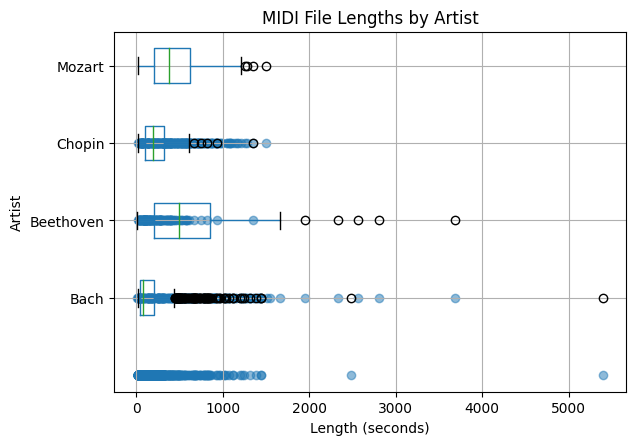

In [171]:
paths_artist_length_data = get_midi_lengths_for_artists(
    raw_data_extracted, specific_artists
)
paths_artist_length_data.to_pickle("paths_artist_length_data.pkl")


### Temple Change Augmentation to handle class imbalance.

In [137]:
# Data Augmentation (Pitch Shifting)
def augment_midi_pitch_shift(file_path, output_dir, shift=2):
    try:
        midi_file = MidiFile(file_path)
        new_midi_file = MidiFile()

        for track in midi_file.tracks:
            new_track = mido.MidiTrack()
            new_midi_file.tracks.append(new_track)
            for msg in track:
                if msg.type == "note_on" or msg.type == "note_off":
                    msg.note = min(max(msg.note + shift, 0), 127)
                new_track.append(msg)

        output_path = os.path.join(
            output_dir,
            os.path.basename(file_path).replace(".mid", f"_pitch_{shift}.mid"),
        )
        new_midi_file.save(output_path)

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")


def process_and_augment_midi_files(
    raw_data_extracted,
    specific_artists,
    output_subdir="augmented_pitch",
    shifts=[2, -2],
):
    # Create the output directory
    augmented_pitch_dir = os.path.join(raw_data_extracted, output_subdir)
    os.makedirs(augmented_pitch_dir, exist_ok=True)

    # Walk through the directory and process MIDI files
    for root, dirs, files in os.walk(raw_data_extracted):
        for file in files:
            if file.endswith(".mid"):
                # Check if any artist name in specific_artists is in the file path
                if any(
                    artist in os.path.join(root, file) for artist in specific_artists
                ):
                    file_path = os.path.join(root, file)
                    for shift in shifts:
                        augment_midi_pitch_shift(
                            file_path, augmented_pitch_dir, shift=shift
                        )


process_and_augment_midi_files(raw_data_extracted, specific_artists)


Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Ignoring the few files that are not working, as we have a good amount of data.

## Long Short-Term Memory (LSTM)

From here and down, the content is divided into types of models tried within the project: Long short-term memory (LSTM) and Convolutional Neural Network (CNN). 

### Feature Extraction

#### Extracting Features Function

In [45]:
# Feature Extraction
def extract_features(file_path):
    try:
        midi_file = MidiFile(file_path)
        features = {
            "length": 0,
            "num_notes": 0,
            "note_freq": Counter(),
            "tempo_changes": [],
            "velocities": [],
            "time_sigs": Counter(),
            "key_sigs": Counter(),
            "polyphony": [],
        }

        note_on_times = {}
        polyphony_count = Counter()

        for track in midi_file.tracks:
            current_time = 0.0
            for msg in track:
                current_time += tick2second(
                    msg.time, midi_file.ticks_per_beat, bpm2tempo(120)
                )

                if msg.type == "note_on" and msg.velocity > 0:
                    features["num_notes"] += 1
                    features["note_freq"][msg.note] += 1
                    features["velocities"].append(msg.velocity)
                    if current_time in note_on_times:
                        note_on_times[current_time].append(msg.note)
                    else:
                        note_on_times[current_time] = [msg.note]
                elif msg.type == "set_tempo":
                    features["tempo_changes"].append(mido.tempo2bpm(msg.tempo))
                elif msg.type == "time_signature":
                    features["time_sigs"][(msg.numerator, msg.denominator)] += 1
                elif msg.type == "key_signature":
                    features["key_sigs"][msg.key] += 1

        features["length"] = current_time

        for time, notes in note_on_times.items():
            polyphony_count[len(notes)] += 1
        features["polyphony"] = polyphony_count

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
        return None
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")
        return None

    return features


In [46]:
# Extract features from all MIDI files, including augmented files
features_list = []

for root, dirs, files in os.walk(raw_data_extracted):
    for file in files:
        if file.endswith(".mid"):
            for artist in specific_artists:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features["path"] = os.path.join(root, file)
                        features["artist"] = artist
                        features_list.append(features)

# Also include features from the augmented directory
for root, dirs, files in os.walk(augmented_pitch_dir):
    for file in files:
        if file.endswith(".mid"):
            for artist in specific_artists:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features["path"] = os.path.join(root, file)
                        features["artist"] = artist
                        features_list.append(features)

# Convert to DataFrame for analysis
features_list_df = pd.DataFrame(features_list)

# Print extracted features
print("Extracted features:")
features_list_df.head()


Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Extracted features:


,length,num_notes,note_freq,tempo_changes,velocities,time_sigs,key_sigs,polyphony,path,artist
0,0.000000,567,"{51: 4, 48: 7, 55: 16, 60: 24, 63: 31, 62: 22,...",[140.00014000014],"[88, 92, 81, 82, 84, 89, 103, 94, 91, 93, 80, ...","{(4, 8): 1}",{'Bb': 1},"{1: 523, 3: 2, 2: 19}",raw_data_unzipped/C.P.E.Bach/C.P.E.Bach Solfeg...,Bach
1,0.000000,4301,"{56: 190, 68: 134, 67: 161, 61: 108, 64: 88, 6...","[55.99997760000896, 50.0, 44.000011733336464, ...","[70, 70, 60, 60, 60, 70, 70, 60, 60, 60, 70, 7...","{(4, 4): 15, (8, 4): 5, (3, 4): 1, (5, 4): 5, ...","{'Ab': 3, 'F': 2}","{2: 508, 1: 2356, 3: 142, 4: 49, 5: 2, 7: 19, ...",raw_data_unzipped/Busoni/Fantasia Nach J. S. B...,Bach
2,539.194792,6517,"{37: 131, 44: 441, 49: 265, 52: 141, 56: 416, ...","[160.0, 89.9999550000225, 160.0, 140.000140000...","[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 5...","{(4, 4): 1}",{'C': 1},"{1: 4167, 6: 2, 5: 2, 2: 802, 3: 232, 4: 3, 8: 2}",raw_data_unzipped/Beethoven/Piano Sonata No.27...,Beethoven
3,136.916667,1019,"{72: 80, 77: 13, 69: 41, 65: 79, 67: 41, 74: 4...","[165.000165000165, 165.000165000165, 165.00016...","[60, 60, 92, 60, 60, 92, 60, 60, 60, 60, 60, 6...","{(6, 8): 1}",{'F': 1},"{3: 80, 2: 279, 1: 217, 4: 1}","raw_data_unzipped/Beethoven/Sieben Bagatellen,...",Beethoven
4,1.500000,708,"{67: 69, 72: 42, 64: 26, 60: 29, 76: 21, 74: 1...","[89.9999550000225, 69.00001725000432, 89.99995...","[91, 94, 96, 97, 100, 98, 94, 95, 88, 70, 55, ...","{(4, 4): 1}",{'C': 1},"{4: 13, 5: 30, 6: 19, 2: 1, 3: 4, 7: 28, 8: 15...",raw_data_unzipped/Beethoven/Lieder op48 n4 ''D...,Beethoven


In [47]:
# Handling Outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])


for col in ["length", "num_notes"]:
    handle_outliers(features_list_df, col)


#### EDA Visuals

<Figure size 1200x600 with 0 Axes>

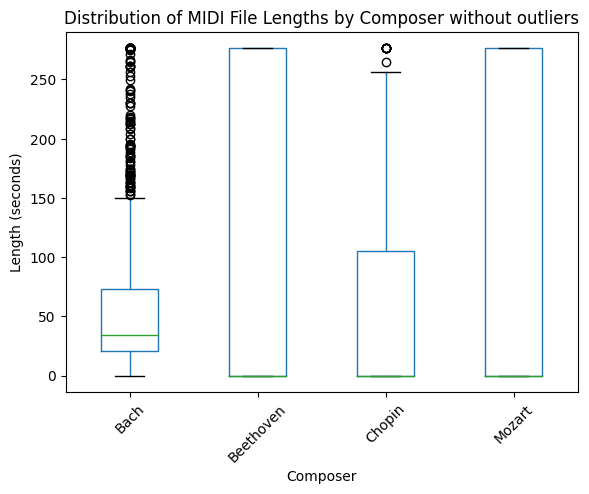

In [48]:
# Distribution of MIDI file lengths by composer after outlier removal
plt.figure(figsize=(12, 6))
features_list_df.boxplot(by="artist", column=["length"], grid=False)
plt.title("Distribution of MIDI File Lengths by Composer without outliers")
plt.suptitle("")
plt.xlabel("Composer")
plt.ylabel("Length (seconds)")
plt.xticks(rotation=45)
plt.show()

<Figure size 600x400 with 0 Axes>

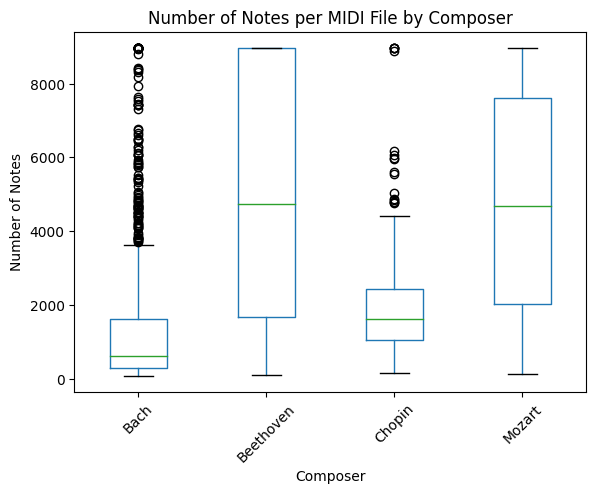

In [49]:
# Number of notes per MIDI file by composer
plt.figure(figsize=(6, 4))
features_list_df.boxplot(by='artist', column=['num_notes'], grid=False)
plt.title('Number of Notes per MIDI File by Composer')
plt.suptitle('')
plt.xlabel('Composer')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45)
plt.show()

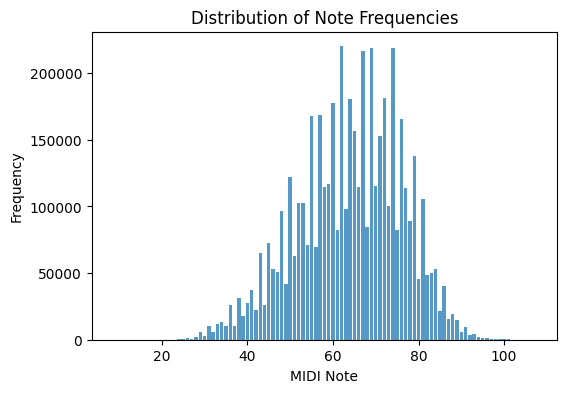

In [50]:
# Distribution of note frequencies
note_freqs = Counter()
for note_counter in features_list_df['note_freq']:
    note_freqs.update(note_counter)

plt.figure(figsize=(6, 4))
plt.bar(note_freqs.keys(), note_freqs.values(), alpha=0.75)
plt.title('Distribution of Note Frequencies')
plt.xlabel('MIDI Note')
plt.ylabel('Frequency')
plt.show()

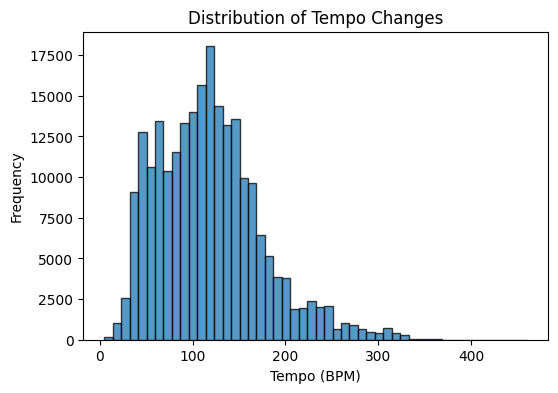

In [51]:
# Distribution of tempo changes
tempo_changes = [
    tempo for sublist in features_list_df["tempo_changes"] for tempo in sublist
]

plt.figure(figsize=(6, 4))
plt.hist(tempo_changes, bins=50, alpha=0.75, edgecolor="black")
plt.title("Distribution of Tempo Changes")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Frequency")
plt.show()


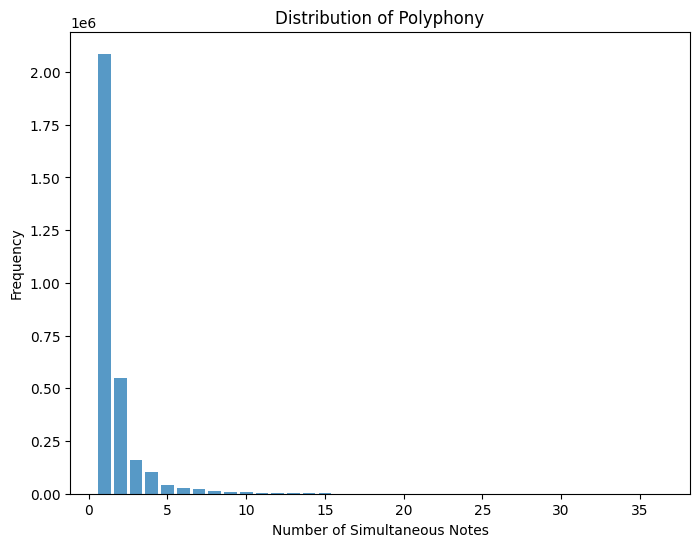

In [52]:
# Distribution of polyphony
polyphony_count = Counter()
for polyphony_counter in features_list_df['polyphony']:
    polyphony_count.update(polyphony_counter)

plt.figure(figsize=(8, 6))
plt.bar(polyphony_count.keys(), polyphony_count.values(), alpha=0.75)
plt.title('Distribution of Polyphony')
plt.xlabel('Number of Simultaneous Notes')
plt.ylabel('Frequency')
plt.show()

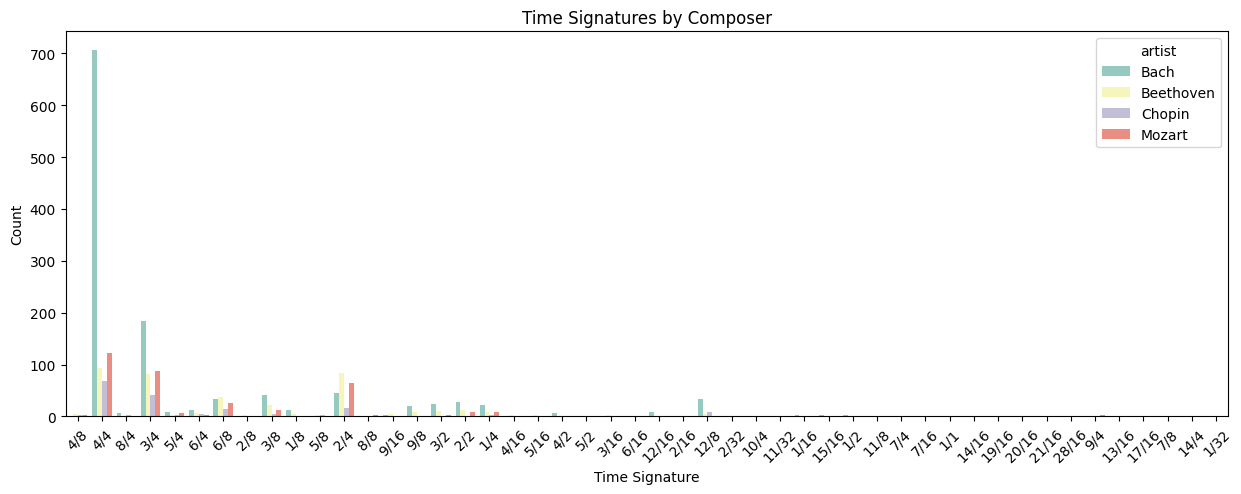

In [53]:
# Time signatures by composer
time_sigs_flat = []
for idx, row in features_list_df.iterrows():
    for time_sig, count in row["time_sigs"].items():
        time_sigs_flat.append(
            {
                "artist": row["artist"],
                "time_signature": f"{time_sig[0]}/{time_sig[1]}",
                "count": count,
            }
        )

time_sigs_df = pd.DataFrame(time_sigs_flat)

plt.figure(figsize=(15, 5))
sns.countplot(data=time_sigs_df, x="time_signature", hue="artist", palette="Set3")
plt.title("Time Signatures by Composer")
plt.xlabel("Time Signature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


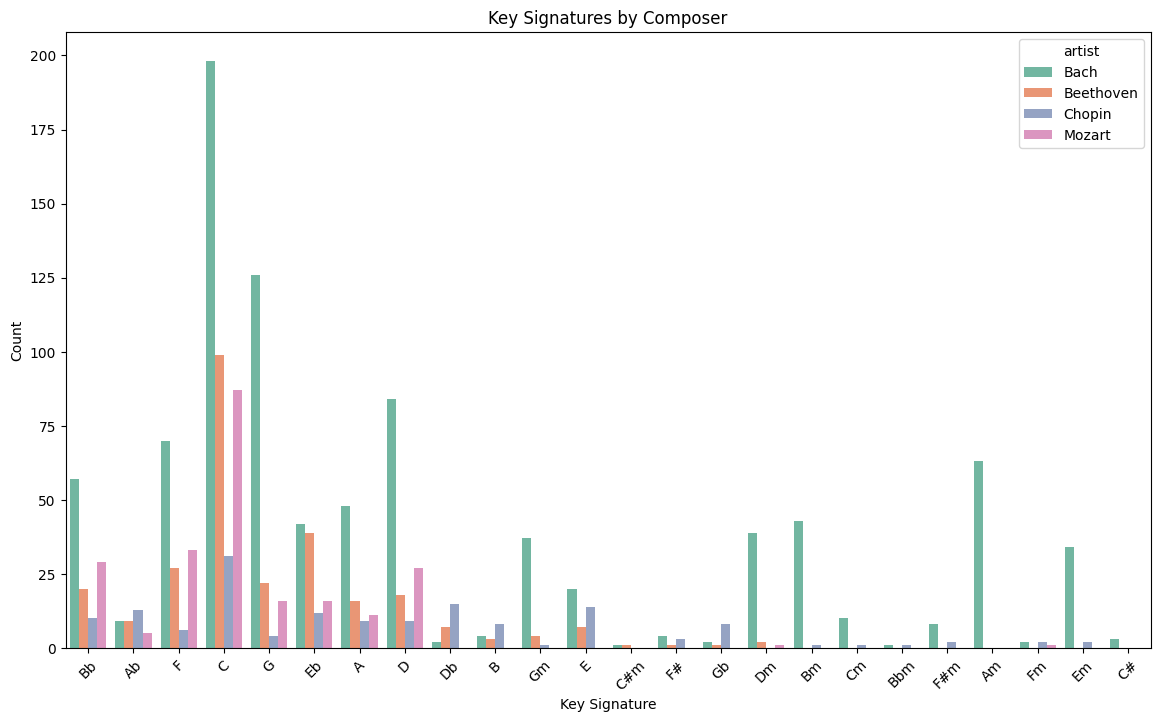

In [54]:
# Key signatures by composer
key_sigs_flat = []
for idx, row in features_list_df.iterrows():
    for key_sig, count in row["key_sigs"].items():
        key_sigs_flat.append(
            {"artist": row["artist"], "key_signature": key_sig, "count": count}
        )

key_sigs_df = pd.DataFrame(key_sigs_flat)

plt.figure(figsize=(14, 8))
sns.countplot(data=key_sigs_df, x="key_signature", hue="artist", palette="Set2")
plt.title("Key Signatures by Composer")
plt.xlabel("Key Signature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [56]:
features_list_df.to_pickle('extracted_features.pkl')

#### Ten Second Random Audio Samples

In [9]:
# Function to list MIDI files for a composer
def list_midi_files(directory, composer):
    composer_dir = os.path.join(directory, composer)
    return [
        os.path.join(composer_dir, file)
        for file in os.listdir(composer_dir)
        if file.endswith(".mid")
    ]


# Function to play a MIDI file for a specified duration
def play_midi(file_path, duration=10):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    time.sleep(duration)
    pygame.mixer.music.stop()


# Dictionary to hold a randomly selected MIDI file for each composer
selected_files = {}

# Select one random MIDI file for each composer
for composer in specific_artists:
    midi_files = list_midi_files(raw_data_extracted, composer)
    if midi_files:
        selected_files[composer] = random.choice(midi_files)
    else:
        print(f"No MIDI files found for {composer}")

# Play the selected MIDI files
for composer, file_path in selected_files.items():
    print(f"Playing {composer}'s selected MIDI file: {file_path}")
    play_midi(file_path)


Playing Bach's selected MIDI file: raw_data_unzipped/Bach/Bwv0544 Prelude and Fugue.mid
Playing Beethoven's selected MIDI file: raw_data_unzipped/Beethoven/Bagatella op33 n5.mid
Playing Chopin's selected MIDI file: raw_data_unzipped/Chopin/Prelude n03 op28 ''Thou Art So Like A Flower''.mid
Playing Mozart's selected MIDI file: raw_data_unzipped/Mozart/K393 Solfeggi n1.mid


### Loading Dataset

In [200]:
## In case if we need to directly load in
# features_list_df = pd.read_pickle('extracted_features.pkl')
# features_list_df.head()

### Preparing Data

In [201]:
# Handle missing values if any
features_list_df.fillna(0, inplace=True)

# Encode the artist labels
label_encoder = LabelEncoder()
features_list_df["artist_encoded"] = label_encoder.fit_transform(
    features_list_df["artist"]
)

# Standardize the features
scaler = StandardScaler()
numeric_features = ["length", "num_notes"]
scaled_features = scaler.fit_transform(features_list_df[numeric_features])

# Prepare sequences
X = []
y = []
sequence_length = 10  # Adjust as necessary

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i : i + sequence_length])
    y.append(features_list_df["artist_encoded"].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1298, 10, 2) (325, 10, 2) (1298, 4) (325, 4)


### Defining the LSTM Model

In [202]:
# Define the LSTM model
model = Sequential()
model.add(
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)
)
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation="softmax"))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           67072     
                                                                 
 dropout_177 (Dropout)       (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_178 (Dropout)       (None, 64)                0         
                                                                 
 dense_118 (Dense)           (None, 4)                 260       
                                                                 
Total params: 116,740
Trainable params: 116,740
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [203]:
backend.clear_session()
tf.compat.v1.reset_default_graph()

In [204]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0,
)


### Evaluating the Model

#### Visualizing Training History

In [8]:
def plot_training_history(history, figsize=(12, 4)):
    metrics = ["accuracy", "loss"]
    plt.figure(figsize=figsize)
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)

        if metric in history.history:
            plt.plot(history.history[metric])
            plt.plot(history.history[f"val_{metric}"])
            plt.title(f"Model {metric}")
            plt.ylabel(metric.capitalize())
            plt.xlabel("Epoch")
            plt.legend(["Train", "Test"], loc="upper left")
        else:
            plt.text(
                0.5,
                0.5,
                f"No {metric} data available",
                horizontalalignment="center",
                verticalalignment="center",
                transform=plt.gca().transAxes,
            )
            plt.title(f"Model {metric}")
            plt.ylabel(metric.capitalize())
            plt.xlabel("Epoch")
    plt.tight_layout()
    plt.show()


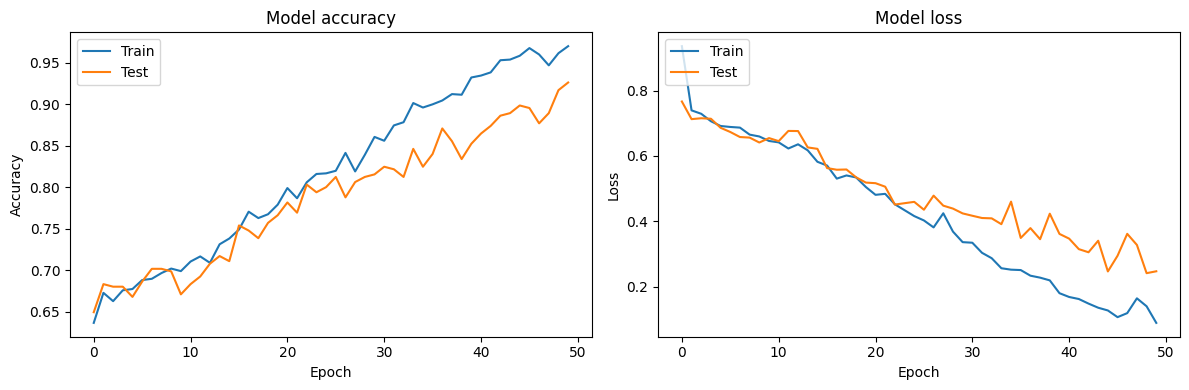

In [206]:
plot_training_history(history)


In [205]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Convert encoded labels back to original
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Display some predictions
for i in range(10):
    print(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")

11/11 [==============================] - 0s 2ms/step - loss: 0.2468 - accuracy: 0.9262
Test Loss: 0.24684257805347443, Test Accuracy: 0.926153838634491
True: Beethoven, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Mozart, Predicted: Mozart
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach


#### Evaluation Metrics

11/11 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.9015
Test Loss: 0.28913936018943787, Test Accuracy: 0.9015384912490845
Classification Report:
              precision    recall  f1-score   support

        Bach       0.96      0.92      0.94       213
   Beethoven       0.85      0.93      0.89        43
      Chopin       0.81      0.81      0.81        26
      Mozart       0.76      0.81      0.79        43

    accuracy                           0.90       325
   macro avg       0.84      0.87      0.86       325
weighted avg       0.90      0.90      0.90       325



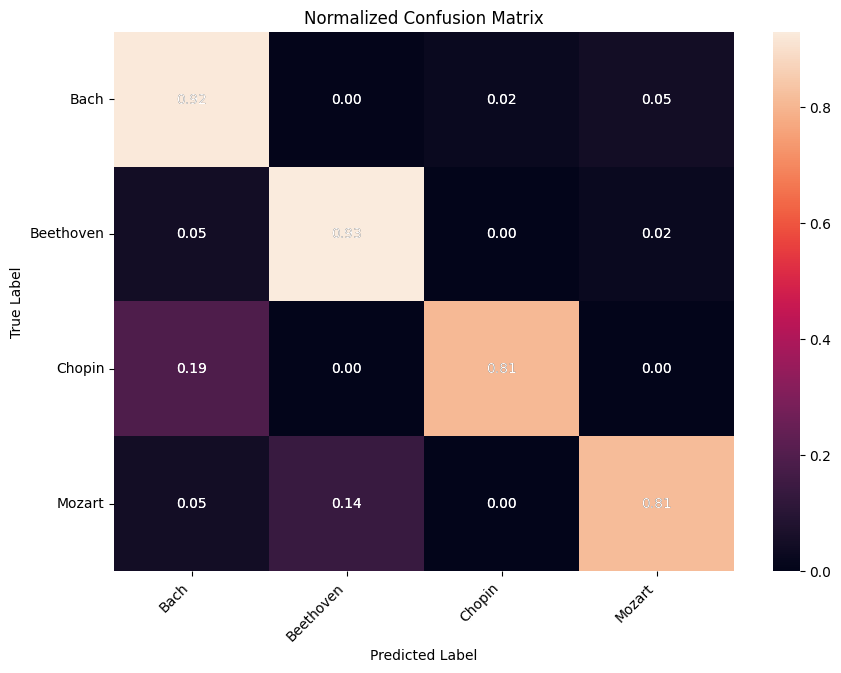

In [65]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Convert encoded labels back to original
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Classification report
print("Classification Report:")
print(
    classification_report(
        true_classes, predicted_classes, target_names=label_encoder.classes_
    )
)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt=".2f",
    cmap="rocket",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha="right")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha="right")

# Annotate each cell with the numeric value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5,
            i + 0.5,
            f"{conf_matrix_normalized[i, j]:.2f}",
            horizontalalignment="center",
            verticalalignment="center",
            color="white",
        )

plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## Convolutional Neural Network (CNN)

### Data Exploration

#### Understanding Structure

Understanding how data can be used for CNN using a `test_file`.

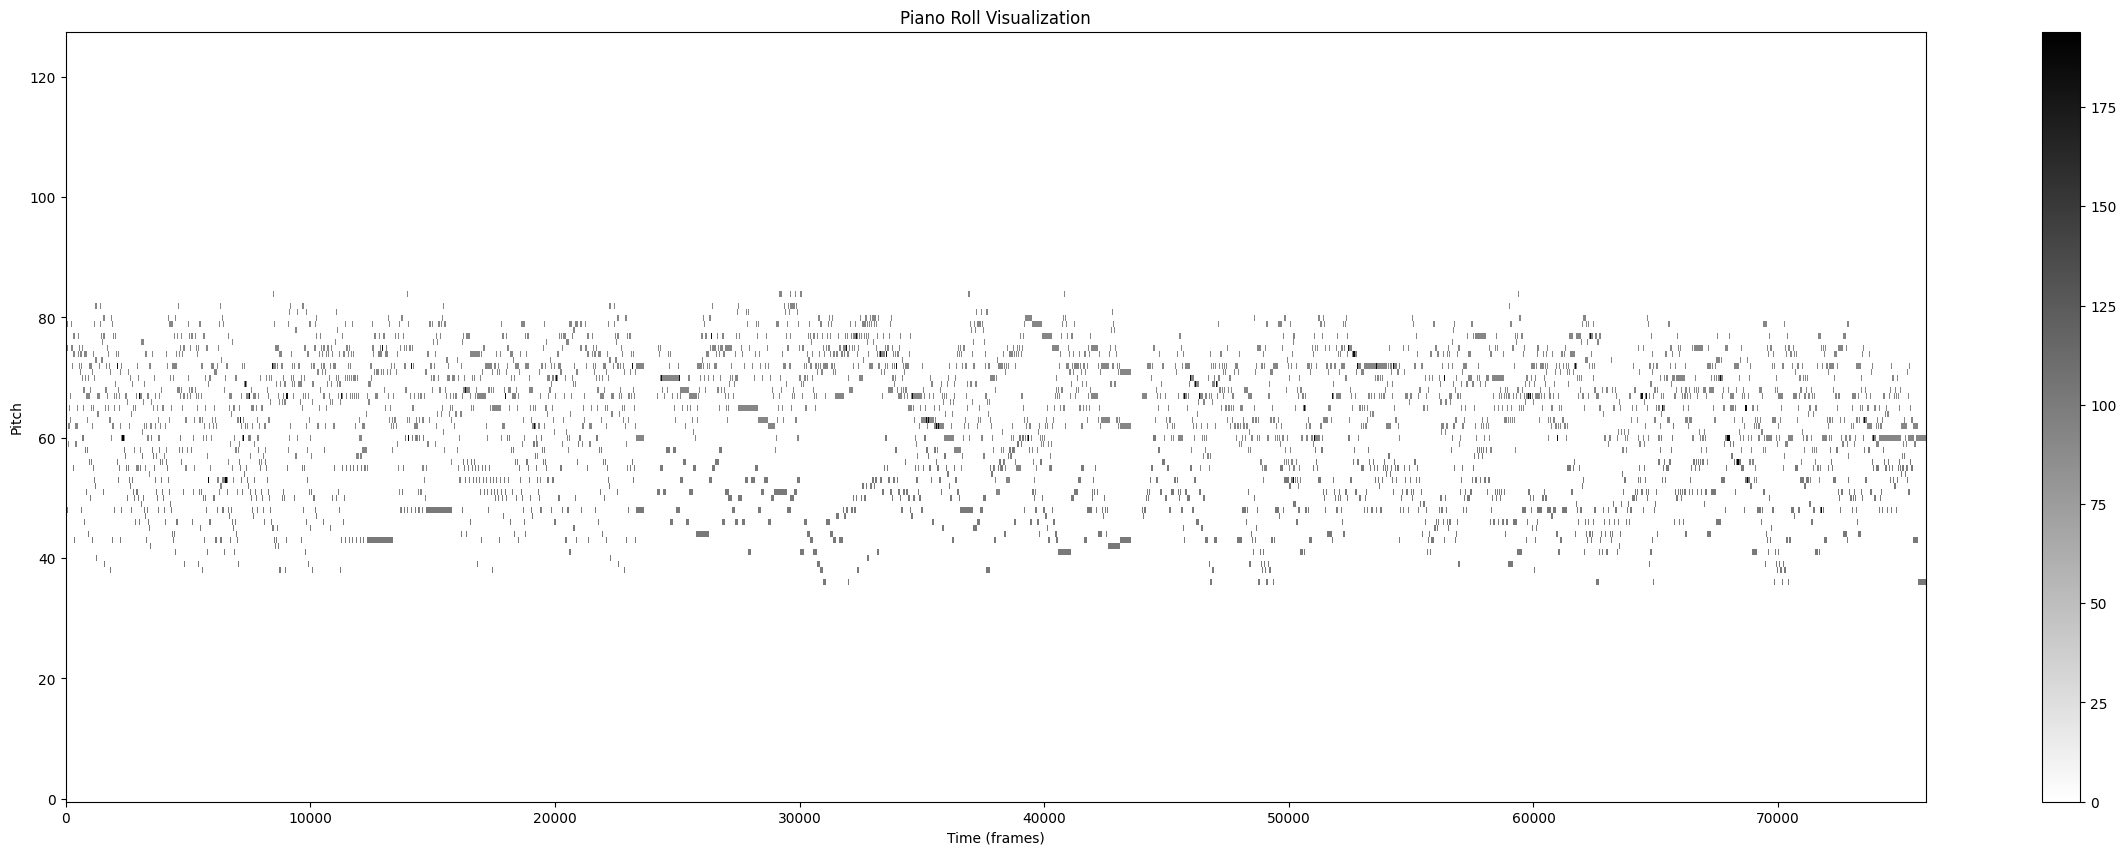

In [66]:
# checking how the data will look like
test_file = raw_data_extracted + "/Bach/Bwv0526 Sonate en trio n2.mid"
# Load MIDI file
midi_data = pretty_midi.PrettyMIDI(test_file)

# Generate piano roll
piano_roll = midi_data.get_piano_roll(fs=100)

# Plot piano roll
plt.figure(figsize=(30, 10))
plt.imshow(
    piano_roll, aspect="auto", origin="lower", cmap="gray_r", interpolation="nearest"
)
plt.xlabel("Time (frames)")
plt.ylabel("Pitch")
plt.title("Piano Roll Visualization")
plt.colorbar()
plt.show()


### Feature Extraction

In this feature extraction process, we convert MIDI files into a multichannel piano roll to capture various aspects of the musical performance:

1. **Binary Roll**: Captures note presence.
2. **Velocity Roll**: Reflects note intensity.
3. **Instrumentation Roll**: Shows which instruments play each note.
4. **Expressive Timing Roll**: Details the timing of notes.


In [67]:
# Processes a MIDI file into a multichannel piano roll (binary, velocity, instrumentation, timing).
def process_multichannel_midi(file_path, fs=10, max_length=100):
    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Binary and velocity piano rolls
    piano_roll = midi_data.get_piano_roll(fs=fs)
    binary_piano_roll = (piano_roll > 0).astype(int)
    velocity_roll = piano_roll / 127  # Normalize velocity

    # Combining instrument rolls, adjusting for length
    instrument_rolls = []
    for instrument in midi_data.instruments:
        inst_roll = instrument.get_piano_roll(fs=fs)
        instrument_rolls.append(inst_roll)

    max_instrument_length = max(inst.shape[1] for inst in instrument_rolls)
    combined_instrument_roll = np.zeros((128, max_instrument_length))
    for inst_roll in instrument_rolls:
        if inst_roll.shape[1] < max_instrument_length:
            # Pad to the right if shorter
            padding = np.zeros((128, max_instrument_length - inst_roll.shape[1]))
            inst_roll = np.hstack((inst_roll, padding))
        combined_instrument_roll += (inst_roll > 0).astype(int)

    # Creating expressive timing roll
    expressive_timing_roll = np.zeros((128, max_instrument_length))
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = int(note.start * fs)
            end = int(note.end * fs)
            expressive_timing_roll[note.pitch, start:end] = 1

    # Adjusting rolls to match the maximum length
    if max_instrument_length > max_length:
        combined_instrument_roll = combined_instrument_roll[:, :max_length]
        expressive_timing_roll = expressive_timing_roll[:, :max_length]
    elif max_instrument_length < max_length:
        padding = np.zeros((128, max_length - max_instrument_length))
        combined_instrument_roll = np.hstack((combined_instrument_roll, padding))
        expressive_timing_roll = np.hstack((expressive_timing_roll, padding))

    binary_piano_roll = binary_piano_roll[:, :max_length]
    velocity_roll = velocity_roll[:, :max_length]

    # Stacking all channels into a multichannel roll
    multichannel_roll = np.stack(
        [
            binary_piano_roll,
            velocity_roll,
            combined_instrument_roll,
            expressive_timing_roll,
        ],
        axis=-1,
    )

    return multichannel_roll


In [ ]:
# Plotting each channel of the processed multichannel piano roll data
def plot_multichannel_piano_roll(processed_data):
    # Unpacking the channels
    binary_channel = processed_data[:, :, 0]
    velocity_channel = processed_data[:, :, 1]
    instrument_channel = processed_data[:, :, 2]
    expressive_timing_channel = processed_data[:, :, 3]

    # Setting up the plot
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))
    titles = [
        "Binary Channel",
        "Velocity Channel",
        "Instrumentation Channel",
        "Expressive Timing Channel",
    ]

    # Plotting each channel
    for ax, channel, title in zip(
        axes,
        [
            binary_channel,
            velocity_channel,
            instrument_channel,
            expressive_timing_channel,
        ],
        titles,
    ):
        cax = ax.imshow(channel, aspect="auto", origin="lower", interpolation="nearest")
        ax.set_title(title)
        ax.set_xlabel("Time")
        ax.set_ylabel("Pitch")
        fig.colorbar(cax, ax=ax, orientation="vertical")

    plt.tight_layout()
    plt.show()


#### Testing Frames Per Second (FPS)

Determining the optimal placement for frames per second (FPS) using visual aids. Trying to see how much of the visual detail is being compressed.

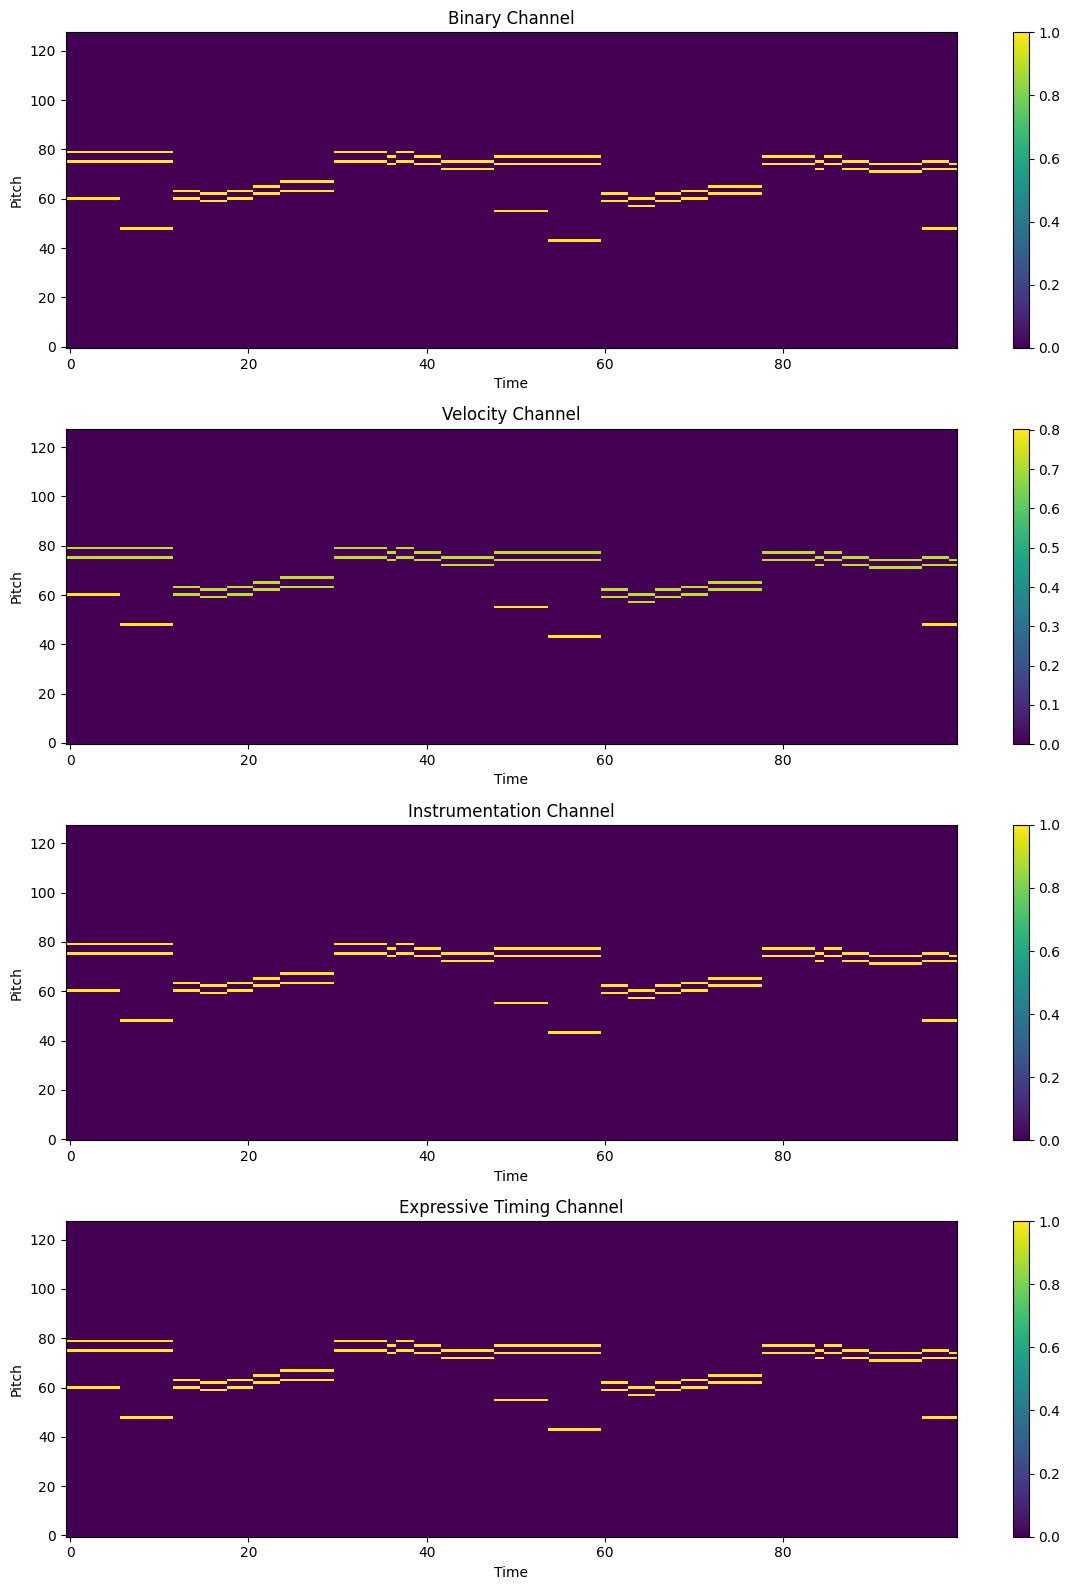

In [138]:
processed_data = process_multichannel_midi(test_file, fs=16)
plot_multichannel_piano_roll(processed_data)

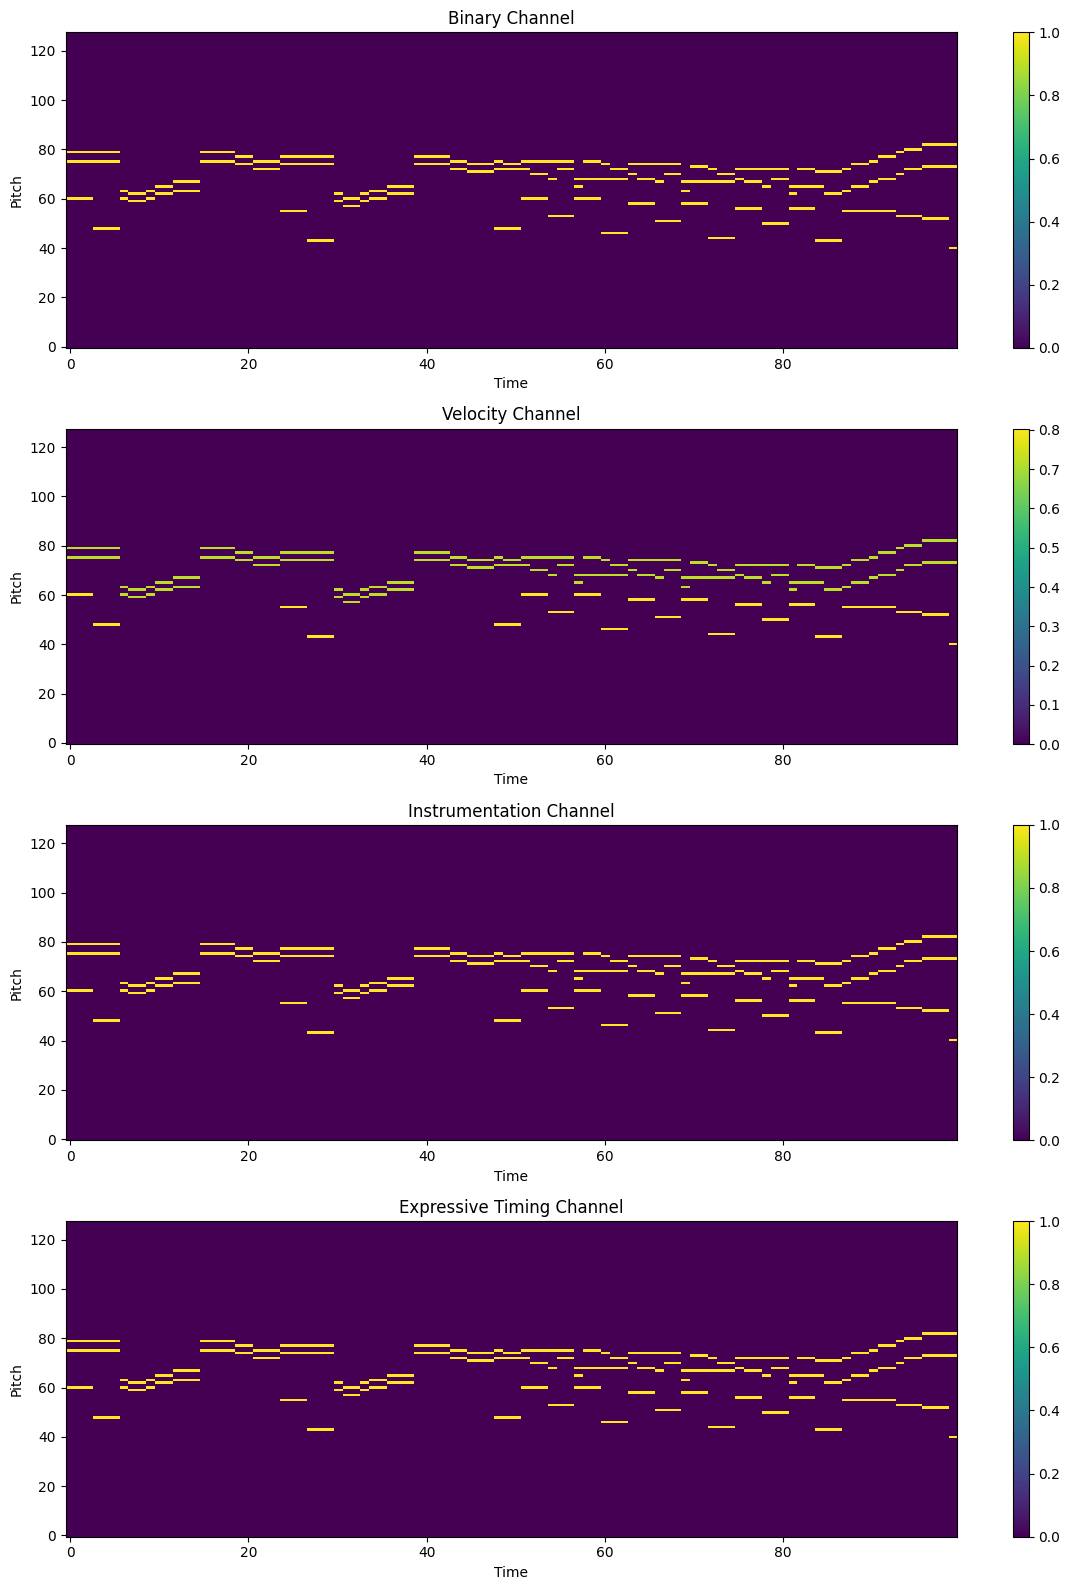

In [68]:
processed_data = process_multichannel_midi(test_file, fs=8)
plot_multichannel_piano_roll(processed_data)

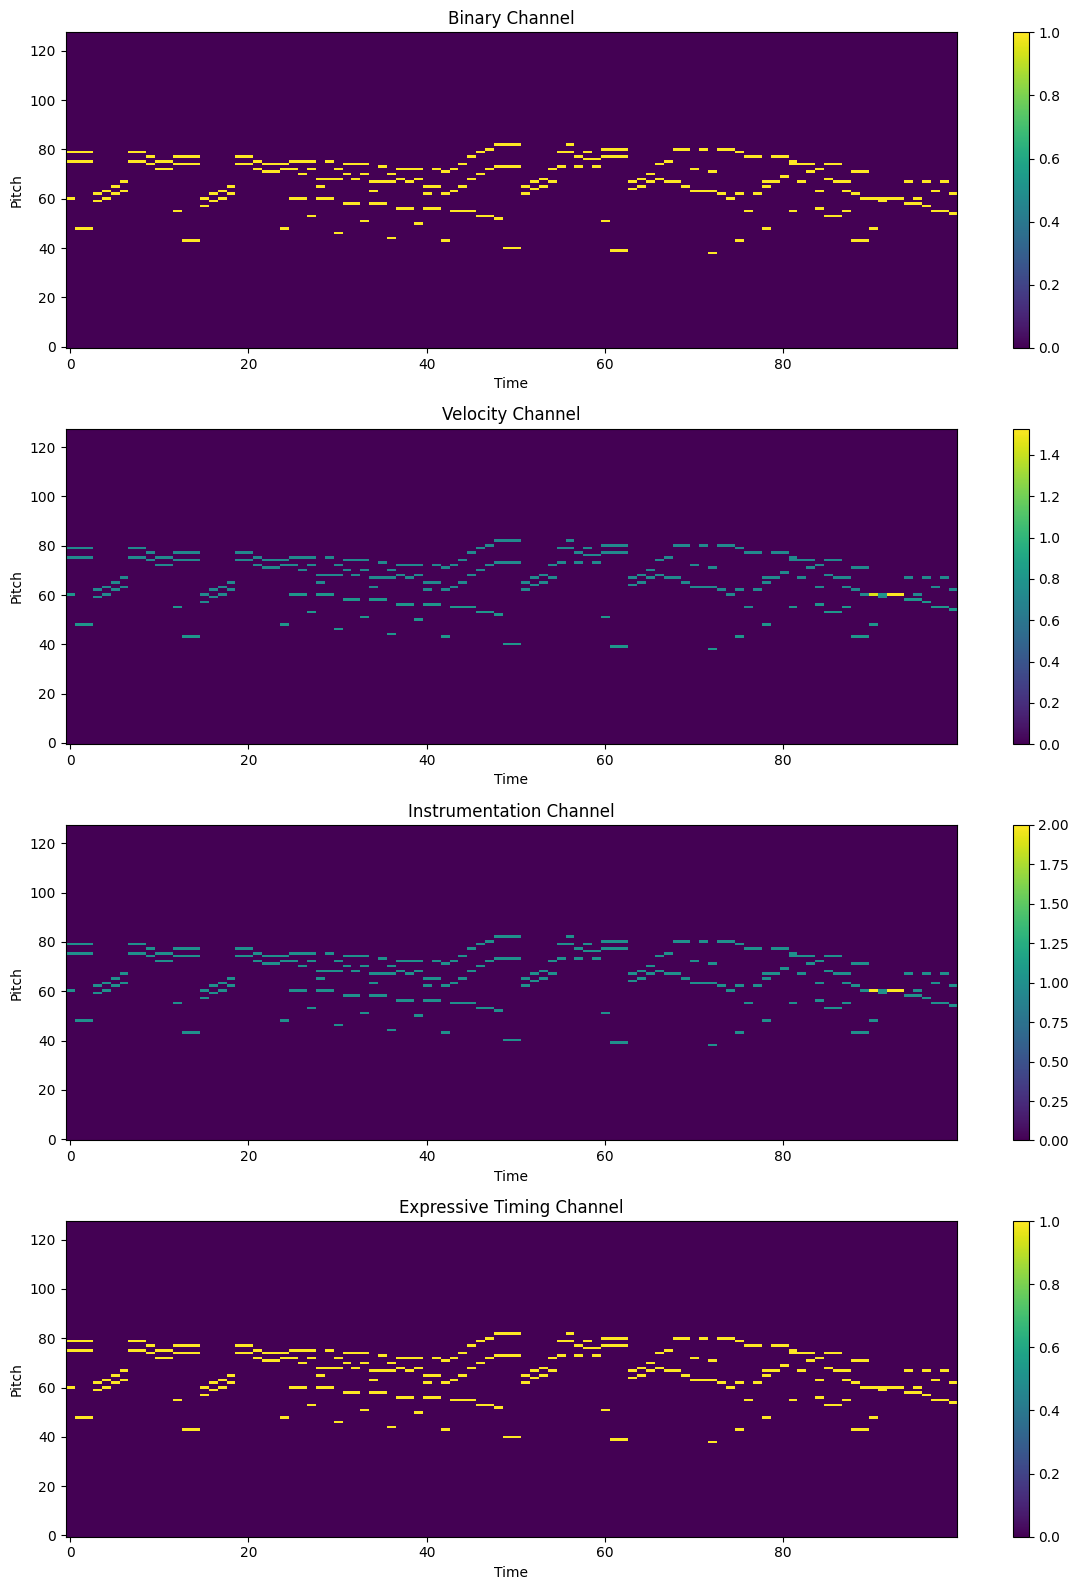

In [69]:
processed_data = process_multichannel_midi(test_file, fs=4)
plot_multichannel_piano_roll(processed_data)

A number around 8 sounds good, will be using 10, just to make it a little compressed.

### Preparing Data

#### Chunks

We divided MIDI files into chunks to classify segments by the artist. This approach reduces bias from different file lengths and focuses on smaller sections instead of the full piece. Also, there is a function to visualize the chunk if needed. 

Also, there is an overlap of information between Binary and Expressive Timing Roll and also between Velocity and Instrumentation Roll. So, we ended up only using the Binary and Velocity. 

In [70]:
def midi_to_chunks(file_path, chunk_size=150, fs=10):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    piano_roll = midi_data.get_piano_roll(fs=fs)
    num_chunks = piano_roll.shape[1] // chunk_size

    chunks = []

    # Creating fixed-size chunks
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunk = piano_roll[:, start:end]

        # Converting to binary and velocity channels
        binary = (chunk > 0).astype(int)
        velocity = chunk / 127

        # Stacking channels
        multichannel_chunk = np.stack([binary, velocity], axis=-1)
        chunks.append(multichannel_chunk)

    # Handling the last chunk if it doesn't fit perfectly
    if piano_roll.shape[1] % chunk_size != 0:
        last_chunk = piano_roll[:, num_chunks * chunk_size :]
        if last_chunk.shape[1] < chunk_size:
            padding = np.zeros((128, chunk_size - last_chunk.shape[1], 2))
            last_chunk_padded = np.stack(
                [(last_chunk > 0).astype(int), last_chunk / 127], axis=-1
            )
            last_chunk_padded = np.concatenate([last_chunk_padded, padding], axis=1)
            chunks.append(last_chunk_padded)

    return chunks


file_path = test_file
chunks = midi_to_chunks(file_path)


In [71]:
def visualize_chunks(chunks):
    num_chunks = len(chunks)
    fig, axes = plt.subplots(
        num_chunks, 2, figsize=(15, 3 * num_chunks)
    )  # 2 columns for binary and velocity

    if num_chunks == 1:
        axes = [axes]

    for i, chunk in enumerate(chunks):
        # Binary Channel
        ax1 = axes[i][0] if num_chunks > 1 else axes[0]
        binary_channel = chunk[:, :, 0]  # Assuming binary channel is the first channel
        cax1 = ax1.imshow(
            binary_channel,
            aspect="auto",
            origin="lower",
            cmap="gray",
            interpolation="none",
        )
        ax1.set_title(f"Chunk {i+1} - Binary Channel")
        ax1.set_xlabel("Time (frames)")
        ax1.set_ylabel("Pitch")
        fig.colorbar(cax1, ax=ax1, orientation="vertical")

        # Velocity Channel
        ax2 = axes[i][1] if num_chunks > 1 else axes[1]
        velocity_channel = chunk[
            :, :, 1
        ]  # Assuming velocity channel is the second channel
        cax2 = ax2.imshow(
            velocity_channel,
            aspect="auto",
            origin="lower",
            cmap="viridis",
            interpolation="none",
        )
        ax2.set_title(f"Chunk {i+1} - Velocity Channel")
        ax2.set_xlabel("Time (frames)")
        ax2.set_ylabel("Pitch")
        fig.colorbar(cax2, ax=ax2, orientation="vertical")

    plt.tight_layout()
    plt.show()


#### Creating `DataFrame` of MIDI Files

In [76]:
# In case if we want to read from a previous run file. 
# paths_artist_length_data  = pd.read_pickle('paths_artist_length_data.pkl')

In [32]:
# Constructing the full file path if necessary
def construct_file_path(base_url, relative_path):
    if not relative_path.startswith(base_url):
        return f"{base_url}/{relative_path}"
    return relative_path


# Iterating over each file to create chunks
def process_all_files(df, base_url, fs=10, chunk_size=150):
    all_chunks = []

    for idx, row in df.iterrows():
        file_path = construct_file_path(base_url, row["path"])
        artist = row["artist"]
        chunks = midi_to_chunks(file_path, chunk_size=chunk_size, fs=fs)

        # Collecting chunks with additional metadata
        for i, chunk in enumerate(chunks):
            all_chunks.append(
                [chunk, artist, row["path"], i + 1, chunk.shape[1] < chunk_size]
            )

    # Creating a DataFrame
    columns = ["Chunk", "Artist", "Original Path", "Chunk Number", "Padding Added"]
    chunk_df = pd.DataFrame(all_chunks, columns=columns)

    return chunk_df


In [75]:
processed_chunk_df = process_all_files(
    paths_artist_length_data, raw_data_extracted, fs=8, chunk_size=150
)
processed_chunk_df.to_pickle("processed_chunk_df.pkl")


#### Synthetic Data Check

In [78]:
print('How many chunks has padding')
print(processed_chunk_df["Padding Added"].value_counts())
print(processed_chunk_df["Padding Added"].value_counts(normalize=True) * 100)

How many chunks has padding
No     39720
Yes     1633
Name: Padding Added, dtype: int64
No     96.051072
Yes     3.948928
Name: Padding Added, dtype: float64


Pretty good percentage.

In [79]:
processed_chunk_df['Chunk'].iloc[0].shape

(128, 150)

#### Input Feature (X)

In [6]:
# Preprocessing chunks from a DataFrame into a format suitable (numpy array) for CNN input
def preprocess_chunks(dataframe, chunk_size=150):

    processed_chunks = []

    for chunk in dataframe["Chunk"]:
        if isinstance(chunk, np.ndarray):
            if chunk.shape[1] != chunk_size:
                if chunk.shape[1] < chunk_size:
                    padding = np.zeros((128, chunk_size - chunk.shape[1]))
                    chunk = np.hstack((chunk, padding))
                else:
                    chunk = chunk[:, :chunk_size]
            processed_chunks.append(chunk)
        else:
            print("Chunk is not a numpy array. Check data preparation steps.")

    # Normalizing data as well
    X = np.stack(processed_chunks) / 127.0
    X = X.reshape(-1, 128, chunk_size, 1)
    return X


In [81]:
X = preprocess_chunks(processed_chunk_df)
X.shape

(41353, 128, 150, 1)

#### Target Variable (y)

In [7]:
# Encoding labels into one-hot format and returning the encoder
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded, label_encoder

In [83]:
y, label_encoder = encode_labels(processed_chunk_df["Artist"])
y.shape

(41353, 4)

In [84]:
X, y = shuffle(X, y, random_state=42)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Defining the CNN Model

Here is what the architecture looks like:

![CNN Initial Model Architecture](models-diagrams/initial-cnn-model.png)

We start with the piano rolls of Binary and Velocity channels and it goes through several layers, ending up within one of the Artists in the end. 

In [86]:
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=X.shape[1:]),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(len(np.unique(processed_chunk_df["Artist"])), activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 36, 64)        0

### Training the Model

In [88]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1034/1034 [==============================] - 11s 9ms/step - loss: 0.8562 - accuracy: 0.6424 - val_loss: 0.6854 - val_accuracy: 0.7225
Epoch 2/10
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6538 - accuracy: 0.7341 - val_loss: 0.6077 - val_accuracy: 0.7631
Epoch 3/10
1034/1034 [==============================] - 8s 8ms/step - loss: 0.5437 - accuracy: 0.7789 - val_loss: 0.5947 - val_accuracy: 0.7704
Epoch 4/10
1034/1034 [==============================] - 8s 7ms/step - loss: 0.4617 - accuracy: 0.8185 - val_loss: 0.5790 - val_accuracy: 0.7820
Epoch 5/10
1034/1034 [==============================] - 8s 8ms/step - loss: 0.3891 - accuracy: 0.8448 - val_loss: 0.5915 - val_accuracy: 0.7900
Epoch 6/10
1034/1034 [==============================] - 8s 8ms/step - loss: 0.3249 - accuracy: 0.8718 - val_loss: 0.6694 - val_accuracy: 0.7861
Epoch 7/10
1034/1034 [==============================] - 8s 8ms/step - loss: 0.2917 - accuracy: 0.8881 - val_loss: 0.6093 - val_accuracy

### Evaluating the Model

#### Visualizing Training History

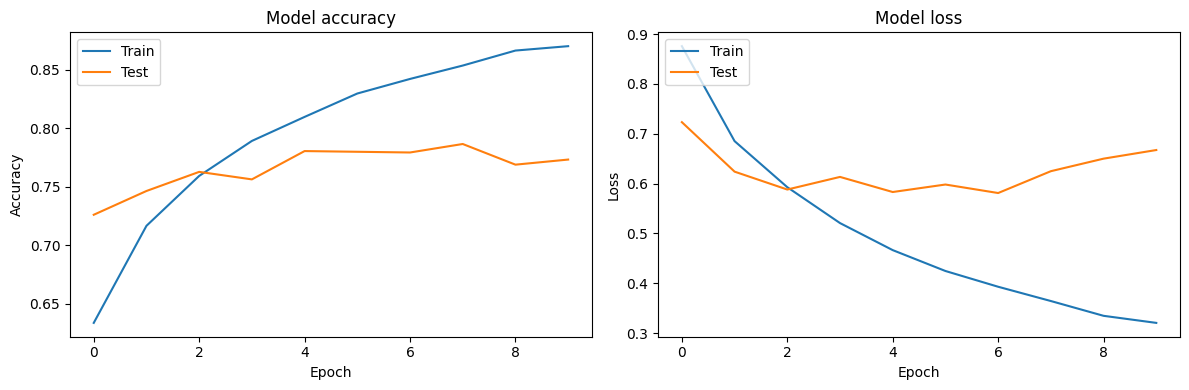

In [142]:
plot_training_history(history)

#### Evaluation Metrics

In [90]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.2f}, Validation loss: {val_loss:.2f}')

259/259 [==============================] - 1s 4ms/step - loss: 0.7263 - accuracy: 0.8021
Validation accuracy: 0.80, Validation loss: 0.73


In [91]:
predictions = model.predict(X_val)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
# Print the top 5 predictions
for i in range(min(5, len(predictions))):
    print(f"{predicted_labels[i]}")


Beethoven

Bach

Bach

Bach

Bach

### Optimization

We built a CNN model with adjustable parameters and used `RandomizedSearchCV` to find the optimal combination of hyperparameters like optimizer, initializer, dropout rate, epochs, and batch size to achieve the best model performance.

In [124]:
# Model to test different parameters against
def create_model(optimizer="adam", init="glorot_uniform", dropout_rate=0.5):
    model = Sequential(
        [
            Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_initializer=init,
                input_shape=X.shape[1:],
            ),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Conv2D(64, (3, 3), activation="relu", kernel_initializer=init),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Flatten(),
            Dense(128, activation="relu", kernel_initializer=init),
            Dropout(dropout_rate),
            Dense(
                len(np.unique(processed_chunk_df["Artist"])),
                activation="softmax",
                kernel_initializer=init,
            ),
        ]
    )

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


model = KerasClassifier(build_fn=create_model, verbose=1)


In [125]:
# Parameter grid for RandomizedSearchCV
param_grid = {
    "optimizer": ["adam", "sgd"],
    "init": ["glorot_uniform", "he_normal"],
    "dropout_rate": [0.4, 0.5],
    "epochs": [10, 20],
    "batch_size": [20, 30],
}

# Initialize and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1
)
random_search_result = random_search.fit(X, y)

print(
    "Best: %f using %s"
    % (random_search_result.best_score_, random_search_result.best_params_)
)

# Please do not mind the scrolling. We initially decided to remove the output
# but decided to keep the results at the last minute as they provide useful
# information to track back.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
1379/1379 [==============================] - 7s 5ms/step - loss: 1.1217 - accuracy: 0.5268
Epoch 2/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.9988 - accuracy: 0.5866
Epoch 3/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.9364 - accuracy: 0.6076
Epoch 4/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.8814 - accuracy: 0.6290
Epoch 5/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.8344 - accuracy: 0.6504
Epoch 6/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.7896 - accuracy: 0.6678
Epoch 7/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.7596 - accuracy: 0.6793
Epoch 8/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.7280 - accuracy: 0.6960
Epoch 9/20
1379/1379 [==============================] - 7s 5ms/step - loss: 0.6983 - accuracy: 0.7081
Epoch 10/20
1379/1379

#### Best Model Parameters

Following are the specific value of the best model:

| Parameter           | Value           |
|---------------------|-----------------|
| Optimizer           | adam            |
| Initialization      | glorot_uniform  |
| Epochs              | 10              |
| Dropout Rate        | 0.4             |
| Batch Size          | 30              |

In [128]:
# Saving the best model
best_model = random_search_result.best_estimator_
best_model.model.save('best_trained_model.h5')
print("Model saved to best_trained_model.h5")

Model saved to best_trained_model.h5


#### Best Model Evaluation

In [129]:
# Evaluate on the validation set
val_loss, val_accuracy = best_model.model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.2f}, Validation loss: {val_loss:.2f}')

259/259 [==============================] - 1s 4ms/step - loss: 0.0836 - accuracy: 0.9797
Validation accuracy: 0.98, Validation loss: 0.08


The best cross-validation accuracy achieved during optimization was 0.7702.

In terms of the Validation and Training, here is the comparison: 

| Metric               | Before Optimization | After Optimization | Improvement Amount |
|----------------------|---------------------|--------------------|--------------------|
| **Validation Accuracy** | 0.80                | 0.98               | +0.18               |
| **Validation Loss**     | 0.73                | 0.08               | -0.65               |
| **Training Accuracy**   | 0.8021              | 0.9797             | +0.1776             |
| **Training Loss**       | 0.7263              | 0.0836             | -0.6427             |


Overall a huge increase in both accuracies and decrease in losses.

## All Artists Inclusive Analysis

Rather than just ending the project with small part of the data, we decided to take the best CNN model and test the full data set against it.

### Loading Dataset

Loading all the artists.

In [44]:
all_artists = get_all_artists(raw_data_extracted)

paths_artist_length_data_all = get_midi_lengths_for_artists(
    raw_data_extracted, all_artists, graph=False, debug=False
)
paths_artist_length_data_all.to_pickle("paths_artist_length_data_all.pkl")


Not a lot of files within some of artists, but since we have chunks, we should have more than one data points of each artist. 

### Preparing Data

In [33]:
processed_chunk_all_df = process_all_files(
    paths_artist_length_data_all, raw_data_extracted, fs=8, chunk_size=150
)
processed_chunk_all_df.to_pickle("processed_chunk_all_artist.pkl")

In [47]:
processed_chunk_all_df = pd.read_pickle('processed_chunk_all_artist.pkl')

In [ ]:
X_all = preprocess_chunks(processed_chunk_all_df)
y_all, label_encoder_all = encode_labels(processed_chunk_all_df['Artist'])

In [8]:
X_all, y_all = shuffle(X_all, y_all, random_state=42)

In [9]:
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

In [10]:
X_all.shape

(164247, 128, 150, 1)

In [11]:
y_all.shape

(164247, 145)

### Defining Model

Here is what the architecture looks like:

![All Artists Inclusive Architecture](models-diagrams/full-cnn-model.png)

In [9]:
def create_best_model(input_shape, output_shape, optimizer="adam", init="glorot_uniform", dropout_rate=0.4):
    model = Sequential(
        [
            Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_initializer=init,
                input_shape=input_shape,
            ),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Conv2D(64, (3, 3), activation="relu", kernel_initializer=init),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Flatten(),
            Dense(128, activation="relu", kernel_initializer=init),
            Dropout(dropout_rate),
            Dense(
                output_shape,
                activation="softmax",
                kernel_initializer=init,
            ),
        ]
    )

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
import warnings
warnings.filterwarnings('ignore')


In [20]:
model = create_best_model(X_all.shape[1:], len(processed_chunk_all_df['Artist'].unique()))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 74, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 36, 64)       

### Training Model

In [23]:
history = model.fit(
    X_train_all, 
    y_train_all, 
    validation_data=(X_val_all, y_val_all),
    epochs=10, 
    batch_size=30, 
    verbose=1
)

Epoch 1/10
4380/4380 [==============================] - 34s 8ms/step - loss: 2.3138 - accuracy: 0.4042 - val_loss: 2.0607 - val_accuracy: 0.4152
Epoch 2/10
4380/4380 [==============================] - 28s 6ms/step - loss: 2.0278 - accuracy: 0.4342 - val_loss: 1.9014 - val_accuracy: 0.4452
Epoch 3/10
4380/4380 [==============================] - 28s 6ms/step - loss: 1.9087 - accuracy: 0.4493 - val_loss: 1.8607 - val_accuracy: 0.4484
Epoch 4/10
4380/4380 [==============================] - 27s 6ms/step - loss: 1.8198 - accuracy: 0.4642 - val_loss: 1.8181 - val_accuracy: 0.4628
Epoch 5/10
4380/4380 [==============================] - 28s 6ms/step - loss: 1.7569 - accuracy: 0.4752 - val_loss: 1.7613 - val_accuracy: 0.4710
Epoch 6/10
4380/4380 [==============================] - 28s 6ms/step - loss: 1.7002 - accuracy: 0.4861 - val_loss: 1.7718 - val_accuracy: 0.4753
Epoch 7/10
4380/4380 [==============================] - 28s 6ms/step - loss: 1.6513 - accuracy: 0.4959 - val_loss: 1.7395 - val_ac

In [25]:
model.save("best_model_all_artists_test.h5")

### Evaluating the Model

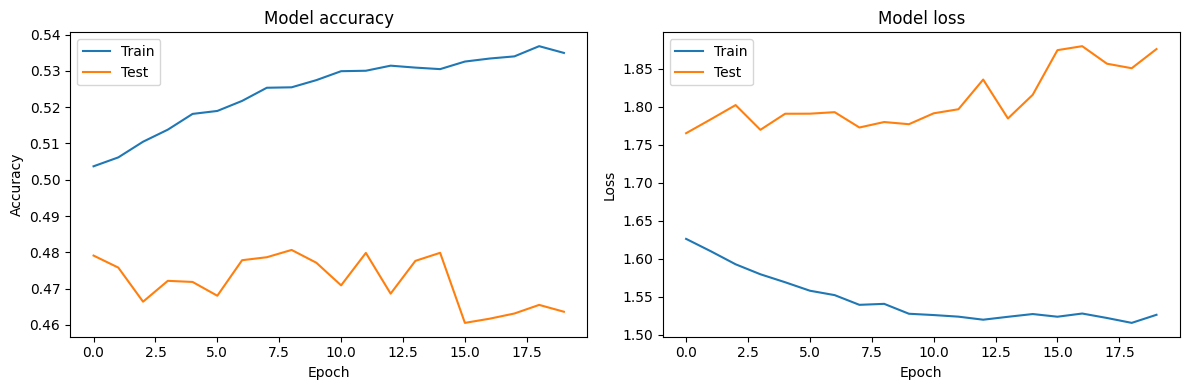

In [32]:
plot_training_history(history)

In [18]:
print(f"Training Loss: {history.history['loss'][-1]}")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

Training Loss: 2.0304393768310547
Training Accuracy: 0.42764294147491455
Validation Loss: 1.9776721000671387
Validation Accuracy: 0.4288584589958191


These are quite lower than the first four artists, especially with the best-case model. 


| Metric                 | Four Artists       | All Artists (Threshold 0) | Difference (All - Four) |
|------------------------|--------------------|---------------------------|-------------------------|
| **Training Loss**       | 0.0836             | 2.0304                    | +1.9468                 |
| **Training Accuracy**   | 97.97%             | 42.76%                    | -55.21%                 |
| **Validation Loss**     | 0.08               | 1.9777                    | +1.8977                 |
| **Validation Accuracy** | 98%                | 42.89%                    | -55.11%                 |


This is a huge change, there might be an issue with presence of low chunks quantity.


#### Checking Chunk Issue

There might be an issue with artists with less chunks causing a huge increase 

In [10]:
def filter_using_threshold(processed_chunk_all_df, threshold):
    # Group by 'Artist' and count the number of rows
    artist_counts = (
        processed_chunk_all_df.groupby("Artist").size().reset_index(name="Count")
    )
    total_rows = len(processed_chunk_all_df)
    artist_counts["Percentage"] = (artist_counts["Count"] / total_rows) * 100
    print("Artist Counts and Percentages:")
    print(artist_counts)

    filtered_artists = artist_counts[artist_counts["Percentage"] > threshold]

    # Print counts of artists below and above the threshold
    below_threshold_count = len(artist_counts[artist_counts["Percentage"] <= threshold])
    above_threshold_count = len(filtered_artists)
    print(
        f"\nNumber of artists below the {threshold}% threshold: {below_threshold_count}"
    )
    print(
        f"Number of artists above the {threshold}% threshold: {above_threshold_count}"
    )

    # Filter the original DataFrame
    filtered_df = processed_chunk_all_df[
        processed_chunk_all_df["Artist"].isin(filtered_artists["Artist"])
    ]

    # Print size of the filtered DataFrame
    print(f"\nFiltered DataFrame size: {len(filtered_df)} rows")

    # Save the filtered DataFrame as a pickle file
    filtered_df.to_pickle("filtered_artists_df.pkl")

    return filtered_df


filtered_df = filter_using_threshold(processed_chunk_all_df, 0.1)


Artist Counts and Percentages:
              Artist  Count  Percentage
0            Albeniz    660    0.401834
1              Alkan    710    0.432276
2           Ambroise     86    0.052360
3            Arensky    152    0.092544
4              Arndt     28    0.017047
..               ...    ...         ...
140          Vivaldi   2790    1.698661
141           Wagner    119    0.072452
142             Wolf     22    0.013394
143  augmented_pitch  59638   36.309948
144       meditation     28    0.017047

[145 rows x 3 columns]

Number of artists below the 0.1% threshold: 96
Number of artists above the 0.1% threshold: 49

Filtered DataFrame size: 159257 rows


2024-08-10 06:59:47.813583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 06:59:48.978788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38416 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:10:1c.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 36, 64)        0

2024-08-10 07:00:11.831576: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8903
2024-08-10 07:00:13.061915: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4247/4247 [==============================] - 39s 8ms/step - loss: 2.1376 - accuracy: 0.4145 - val_loss: 1.8914 - val_accuracy: 0.4374
Epoch 2/10
4247/4247 [==============================] - 29s 7ms/step - loss: 1.9014 - accuracy: 0.4401 - val_loss: 1.8262 - val_accuracy: 0.4328
Epoch 3/10
4247/4247 [==============================] - 29s 7ms/step - loss: 1.8015 - accuracy: 0.4558 - val_loss: 1.7636 - val_accuracy: 0.4578
Epoch 4/10
4247/4247 [==============================] - 29s 7ms/step - loss: 1.7268 - accuracy: 0.4712 - val_loss: 1.6772 - val_accuracy: 0.4726
Epoch 5/10
4247/4247 [==============================] - 29s 7ms/step - loss: 1.6758 - accuracy: 0.4814 - val_loss: 1.6518 - val_accuracy: 0.4760
Epoch 6/10
4247/4247 [==============================] - 29s 7ms/step - loss: 1.6251 - accuracy: 0.4912 - val_loss: 1.6288 - val_accuracy: 0.4834
Epoch 7/10
4247/4247 [==============================] - 28s 7ms/step - loss: 1.5846 - accuracy: 0.5010 - val_loss: 1.6351 - val_accuracy: 0.4

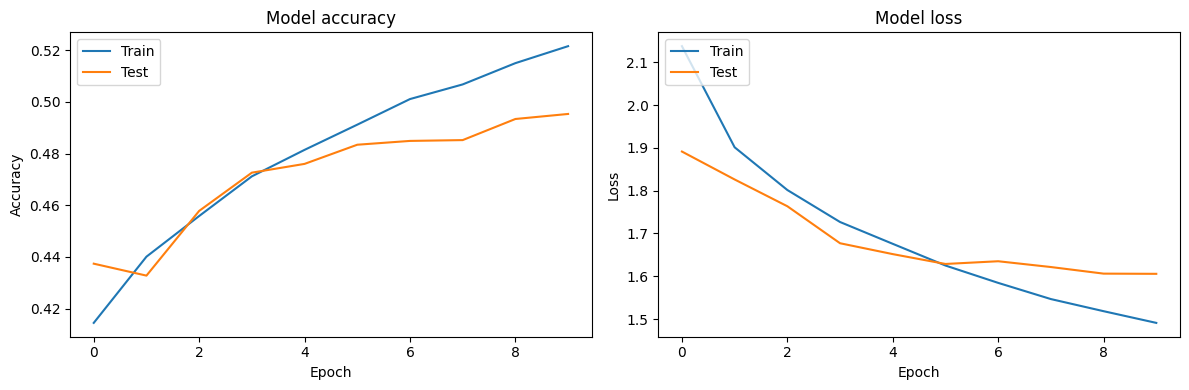

Training Loss: 1.491101622581482
Training Accuracy: 0.5215023159980774
Validation Loss: 1.6057184934616089
Validation Accuracy: 0.49529072642326355


In [11]:
def build_and_analyse_model(filtered_df, info = ""):
    
    X_all = preprocess_chunks(filtered_df)
    y_all, label_encoder_all = encode_labels(filtered_df['Artist'])
    X_all, y_all = shuffle(X_all, y_all, random_state=42)
    X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42
    )
    model = create_best_model(X_all.shape[1:], len(filtered_df['Artist'].unique()))
    model.summary()
    history = model.fit(
        X_train_all, 
        y_train_all, 
        validation_data=(X_val_all, y_val_all),
        epochs=10, 
        batch_size=30, 
        verbose=1
    )
    model.save(f"best_model_all_artists_{info}.h5")
    plot_training_history(history)
    print(f"Training Loss: {history.history['loss'][-1]}")
    print(f"Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"Validation Loss: {history.history['val_loss'][-1]}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

    return model

model_01 = build_and_analyse_model(filtered_df, info = "0_1")

Artist Counts and Percentages:
              Artist  Count  Percentage
0            Albeniz    660    0.401834
1              Alkan    710    0.432276
2           Ambroise     86    0.052360
3            Arensky    152    0.092544
4              Arndt     28    0.017047
..               ...    ...         ...
140          Vivaldi   2790    1.698661
141           Wagner    119    0.072452
142             Wolf     22    0.013394
143  augmented_pitch  59638   36.309948
144       meditation     28    0.017047

[145 rows x 3 columns]

Number of artists below the 1% threshold: 131
Number of artists above the 1% threshold: 14

Filtered DataFrame size: 144721 rows
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 74, 32) 

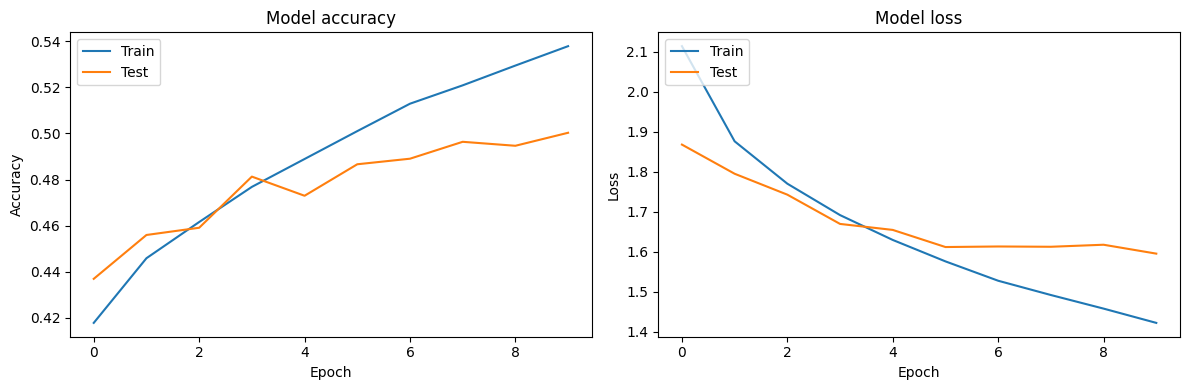

Training Loss: 1.4226192235946655
Training Accuracy: 0.537953794002533
Validation Loss: 1.5956977605819702
Validation Accuracy: 0.500313937664032


In [13]:
filtered_df_1 = filter_using_threshold(processed_chunk_all_df, 1)
model_1 = build_and_analyse_model(filtered_df, info = "1")

Artist Counts and Percentages:
              Artist  Count  Percentage
0            Albeniz    660    0.401834
1              Alkan    710    0.432276
2           Ambroise     86    0.052360
3            Arensky    152    0.092544
4              Arndt     28    0.017047
..               ...    ...         ...
140          Vivaldi   2790    1.698661
141           Wagner    119    0.072452
142             Wolf     22    0.013394
143  augmented_pitch  59638   36.309948
144       meditation     28    0.017047

[145 rows x 3 columns]

Number of artists below the 10% threshold: 143
Number of artists above the 10% threshold: 2

Filtered DataFrame size: 76328 rows
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 74, 32) 

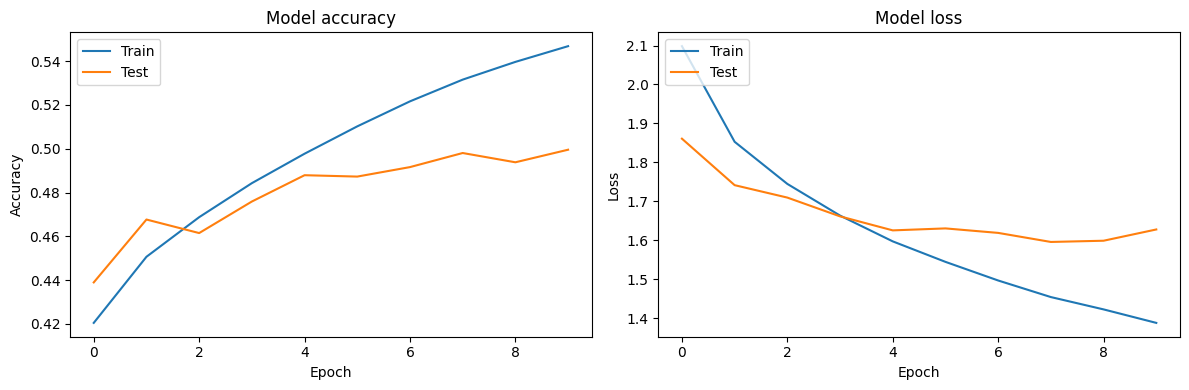

Training Loss: 1.387671947479248
Training Accuracy: 0.546870231628418
Validation Loss: 1.6275787353515625
Validation Accuracy: 0.49956047534942627


In [14]:
filtered_df_10 = filter_using_threshold(processed_chunk_all_df, 10)
model_10 = build_and_analyse_model(filtered_df, info = "10")

Here is the table summarizing of accuracy at different thresholds:

| **Threshold** | **Training Loss** | **Training Accuracy** | **Validation Loss** | **Validation Accuracy** | **Artists Below Threshold** | **Artists Above Threshold** |
|---------------|-------------------|-----------------------|---------------------|-------------------------|-----------------------------|-----------------------------|
| 0             | 2.0304            | 0.4276                | 1.9777              | 0.4289                  | 0                           | 145                         |
| 0.1           | 1.4911            | 0.5215                | 1.6057              | 0.4953                  | 96                          | 49                          |
| 1             | 1.4226            | 0.5380                | 1.5957              | 0.5003                  | 131                         | 14                          |
| 10            | 1.3877            | 0.5469                | 1.6276              | 0.4996                  | 143                         | 2                           |


Two major thing to note:

- Both training and validation accuracy increase with higher thresholds, while training loss decreases. Validation loss, however, shows mixed results.
- The number of artists below the threshold increases as the threshold rises, while those above it decrease sharply.

It would be great to explore this further.

Overall, this project was quite fun for all of us. Not only did we learn quite a lot, but we also achieved great accuracy and optimization. We also got to try on full data, which was initially the main wish, as our data preparation was designed to include all the MIDI files and structure all the files quite nicely. 

## Future Plan

If we had more GPU power, it would be great to optimization the best model for all the artists. Just the small optimization of CNN took us several hours of training within our machines, and even on NVIDIA A100 (40 GB), it took quite a while to get everything running and optimized. We had to pull some parameters out due to minimum resources. 

Additionally, it would be great to create a demo where we can give it a random MIDI chunk and get a prediction, similar to Shazam. We had written some code for this, but nothing was complete for an MVP. It would be great to go back and get the MVP done. 